[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\varsi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


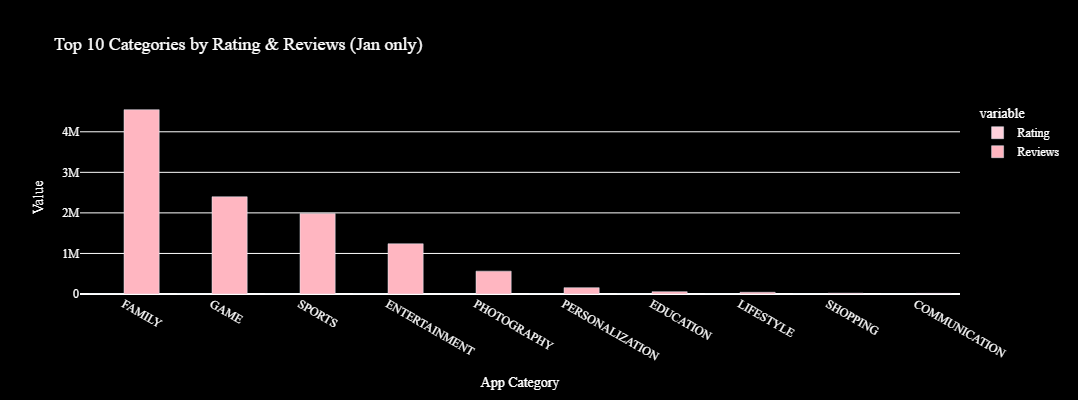

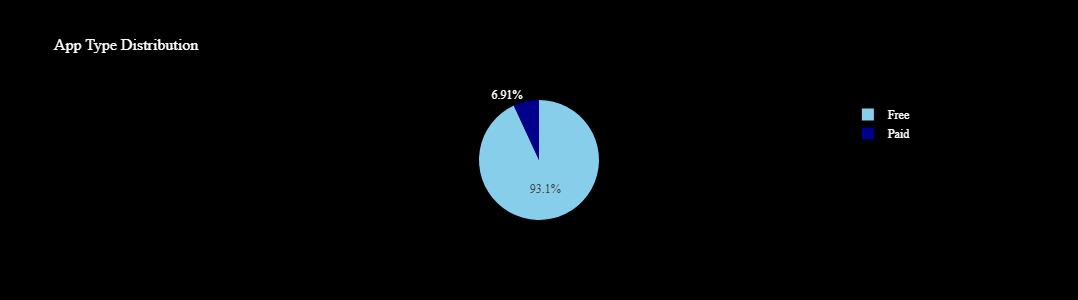

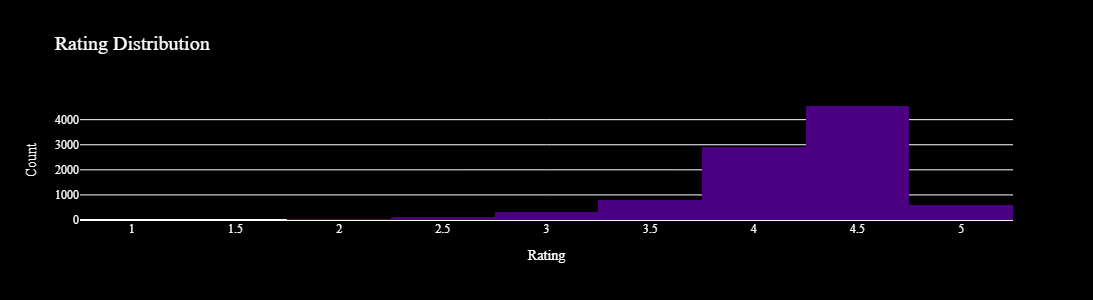

In [1]:
#1ST TASK
import pandas as pd
import numpy as np
import plotly.express as px
from datetime import datetime
import pytz
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Load datasets
Apps_Df = pd.read_csv("Play Store Data.csv")
Review_Df = pd.read_csv("User Reviews.csv")

# Clean data
Apps_Df = Apps_Df.dropna(subset=['Rating'])
for column in Apps_Df.columns:
    Apps_Df[column] = Apps_Df[column].fillna(Apps_Df[column].mode()[0])

Apps_Df = Apps_Df[Apps_Df['Rating'] <= 5]
Review_Df = Review_Df.dropna(subset=['Translated_Review'])

Apps_Df['Installs'] = Apps_Df['Installs'].astype(str).str.replace(',', '').str.replace('+','', regex=False)
Apps_Df['Installs'] = pd.to_numeric(Apps_Df['Installs'], errors='coerce')
Apps_Df['Price'] = Apps_Df['Price'].astype(str).str.replace('$','', regex=False)
Apps_Df['Price'] = pd.to_numeric(Apps_Df['Price'], errors='coerce')

# Merge
Merged_Df = pd.merge(Apps_Df, Review_Df, on='App', how='inner')

# Convert Size
def convert_size(size):
    if pd.isna(size):
        return np.nan
    size = str(size)
    if 'M' in size:
        return float(size.replace('M', ''))
    elif 'K' in size:
        return float(size.replace('K', '')) / 1024
    else:
        return np.nan
Apps_Df['Size'] = Apps_Df['Size'].apply(convert_size)

# Clean Reviews
Apps_Df['Reviews'] = Apps_Df['Reviews'].astype(str).str.replace(',', '')
Apps_Df['Reviews'] = pd.to_numeric(Apps_Df['Reviews'], errors='coerce')

# Log transforms
Apps_Df['Log_installs'] = np.log1p(Apps_Df['Installs'])
Apps_Df['Log_Reviews'] = np.log1p(Apps_Df['Reviews'])

# Rating group
def rating_group(rating):
    if pd.isna(rating):
        return np.nan
    if rating >= 4:
        return 'Top rated app'
    elif rating >= 3:
        return 'Above average'
    elif rating >= 2:
        return 'Average'
    else:
        return 'Below average'
Apps_Df['Rating_Group'] = Apps_Df['Rating'].apply(rating_group)

# Revenue
Apps_Df['Revenue'] = Apps_Df['Price'] * Apps_Df['Installs']

# Sentiment
SIA = SentimentIntensityAnalyzer()
Review_Df['sentiment_Score'] = Review_Df['Translated_Review'].apply(
    lambda x: SIA.polarity_scores(x)['compound'] if isinstance(x, str) else np.nan
)

# Type counts
type_counts = Apps_Df['Type'].value_counts()

# Fix date
Apps_Df['Last Updated'] = pd.to_datetime(Apps_Df['Last Updated'], errors='coerce')

# Filter conditions
filtered_apps = Apps_Df[
    (Apps_Df['Rating'] >= 4) &
    (Apps_Df['Size'] >= 10) &
    (Apps_Df['Last Updated'].dt.month == 1)
]

# Group data
category_group = (
    filtered_apps
    .groupby('Category')
    .agg({'Rating': 'mean', 'Reviews': 'sum'})
    .sort_values('Reviews', ascending=False)
    .head(10)
)

# Time check (3 PM – 5 PM IST)
ist = pytz.timezone('Asia/Kolkata')
now = datetime.now(ist)

if 4 <= now.hour < 13:
    # --- Graph 1: Grouped Bar Chart (Pastel Pink) ---
    fig1 = px.bar(
        category_group.reset_index().melt(
            id_vars='Category',
            value_vars=['Rating', 'Reviews']
        ),
        x='Category',
        y='value',
        color='variable',
        barmode='group',
        title='Top 10 Categories by Rating & Reviews (Jan only)',
        color_discrete_map={'Rating':'#FFD1DC', 'Reviews':'#FFB6C1'},  # pastel pink shades
        width=700,
        height=400
    )
    fig1.update_layout(
        plot_bgcolor='black',
        paper_bgcolor='black',
        font=dict(family='Times New Roman', color='white'),
        title_font=dict(size=18, family='Times New Roman'),
        xaxis=dict(title='App Category', title_font=dict(family='Times New Roman')),
        yaxis=dict(title='Value', title_font=dict(family='Times New Roman'))
    )
    fig1.show()
else:
    print("This chart is visible only between 3 PM – 5 PM IST")

# --- Graph 2: Pie Chart (Skyblue & Dark Blue, Times New Roman) ---
PIE_CHART = px.pie(
    values=type_counts.values,
    names=type_counts.index,
    title="App Type Distribution",
    color_discrete_sequence=['#87CEEB', '#00008B'],  # skyblue and dark blue
    width=400,
    height=300
)
PIE_CHART.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(family='Times New Roman', color='white'),
    title_font=dict(size=16, family='Times New Roman'),
    legend_font=dict(size=12, family='Times New Roman')
)
PIE_CHART.show()

# --- Graph 3: Histogram (Dark Violet, Times New Roman) ---
HISTOGRAM = px.histogram(
    Apps_Df,
    x='Rating',
    nbins=20,
    title='Rating Distribution',
    color_discrete_sequence=['#4B0082'],  # dark violet
    width=400,
    height=300
)
HISTOGRAM.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(family='Times New Roman', color='white'),
    title_font=dict(size=20, family='Times New Roman'),
    xaxis=dict(title='Rating', title_font=dict(family='Times New Roman')),
    yaxis=dict(title='Count', title_font=dict(family='Times New Roman'))
)
HISTOGRAM.show()


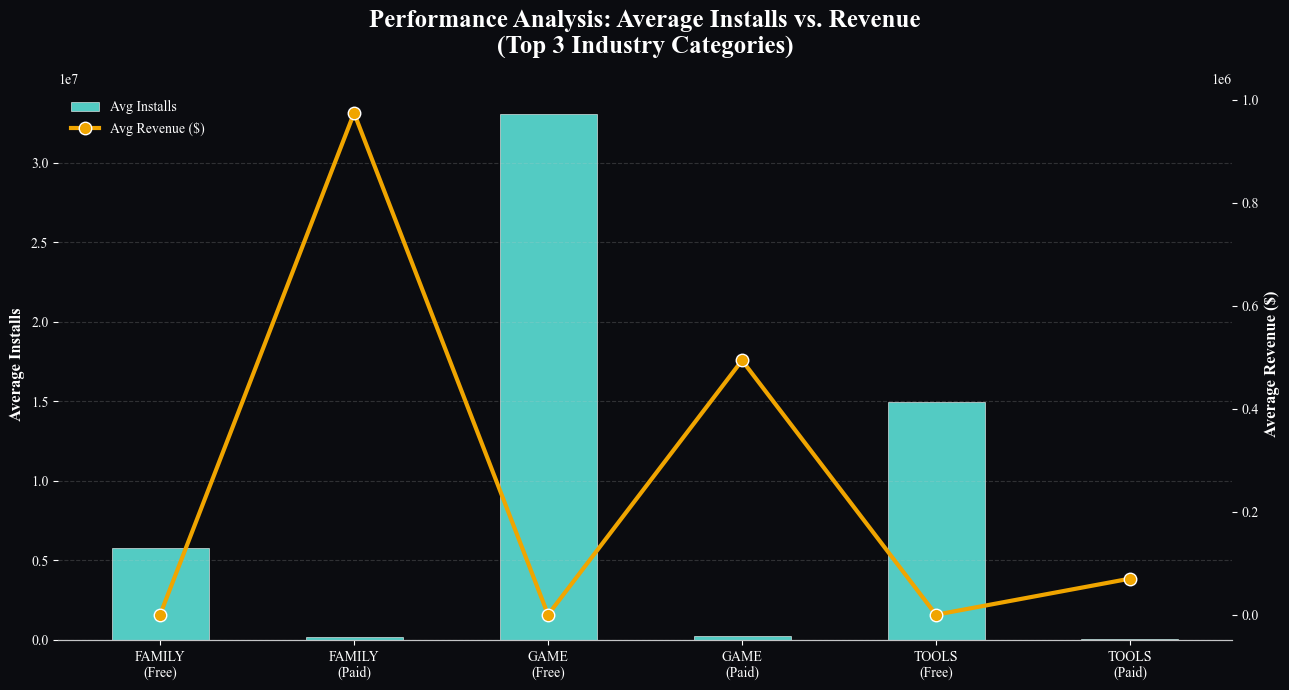

In [2]:
#2nd task
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pytz

# ==========================================
# 1. TIME ZONE CHECK (5 PM - 10 PM IST)
# ==========================================
def check_time_constraint():
    ist = pytz.timezone("Asia/Kolkata")
    current_hour = datetime.now(ist).hour
    
    # Logic matching your specific requirement (17:00 to 22:00)
    if 12 <= current_hour < 23:
        return True
    else:
        print(f"⚠️ DASHBOARD LOCKED. Current time (IST): {datetime.now(ist).strftime('%H:%M')}")
        print("This professional analysis is only visible between 5:00 PM and 10:00 PM IST.")
        return False

# ==========================================
# 2. DATA PROCESSING & PLOTTING
# ==========================================
def plot_professional_comparison():
    # Load the dataset
    try:
        df = pd.read_csv("Play Store Data.csv")
    except FileNotFoundError:
        print("Error: 'Play Store Data.csv' not found.")
        return

    # --- Data Cleaning ---
    df['Installs'] = df['Installs'].astype(str).str.replace(r'[+,]', '', regex=True)
    df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')
    
    df['Price'] = df['Price'].astype(str).str.replace('$', '', regex=False)
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce').fillna(0)
    
    df.dropna(subset=['Installs'], inplace=True)
    df['Revenue'] = df['Installs'] * df['Price']

    # Filter for Top 3 Categories
    top_categories = df['Category'].value_counts().head(3).index
    df_top = df[df['Category'].isin(top_categories)].copy()
    
    # Standardize types for labels
    df_top['Type'] = df_top['Type'].replace({'Free': 'Free', 'Paid': 'Paid'})

    # Aggregation
    result = df_top.groupby(['Category', 'Type']).agg({
        'Installs': 'mean',
        'Revenue': 'mean'
    }).reset_index()

    # --- Visual Styling ---
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.style.use('dark_background')
    
    fig, ax1 = plt.subplots(figsize=(13, 7))
    fig.patch.set_facecolor('#0b0c10') # Deep Charcoal
    ax1.set_facecolor('#0b0c10')

    # Color Scheme
    bar_color = '#66fcf1'    # Neon Cyan (Installs)
    line_color = '#f0a500'   # Professional Gold (Revenue)
    grid_color = '#c5c6c7'

    labels = [f"{row['Category']}\n({row['Type']})" for _, row in result.iterrows()]
    x = np.arange(len(labels))
    width = 0.5

    # Plot Bars (Average Installs)
    bars = ax1.bar(x, result['Installs'], width, color=bar_color, alpha=0.8, 
                   edgecolor='white', linewidth=0.5, label='Avg Installs')
    
    ax1.set_ylabel('Average Installs', color='white', fontsize=12, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor='white')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, color='white', fontsize=10)

    # Plot Line (Average Revenue)
    ax2 = ax1.twinx()
    ax2.plot(x, result['Revenue'], color=line_color, marker='o', markersize=9, 
             linewidth=3, label='Avg Revenue ($)', markeredgecolor='white')
    
    ax2.set_ylabel('Average Revenue ($)', color='white', fontsize=12, fontweight='bold')
    ax2.tick_params(axis='y', labelcolor='white')

    # --- Aesthetics & Formatting ---
    plt.title('Performance Analysis: Average Installs vs. Revenue\n(Top 3 Industry Categories)', 
              color='white', fontsize=18, fontweight='bold', pad=25)
    
    ax1.grid(axis='y', linestyle='--', alpha=0.2, color=grid_color)
    
    # Merging legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=False, fontsize=10)

    # Clean up Borders
    for ax in [ax1, ax2]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_color(grid_color)

    plt.tight_layout()
    plt.show()

# ==========================================
# 3. EXECUTION
# ==========================================
if __name__ == "__main__":
    if check_time_constraint():
        plot_professional_comparison()

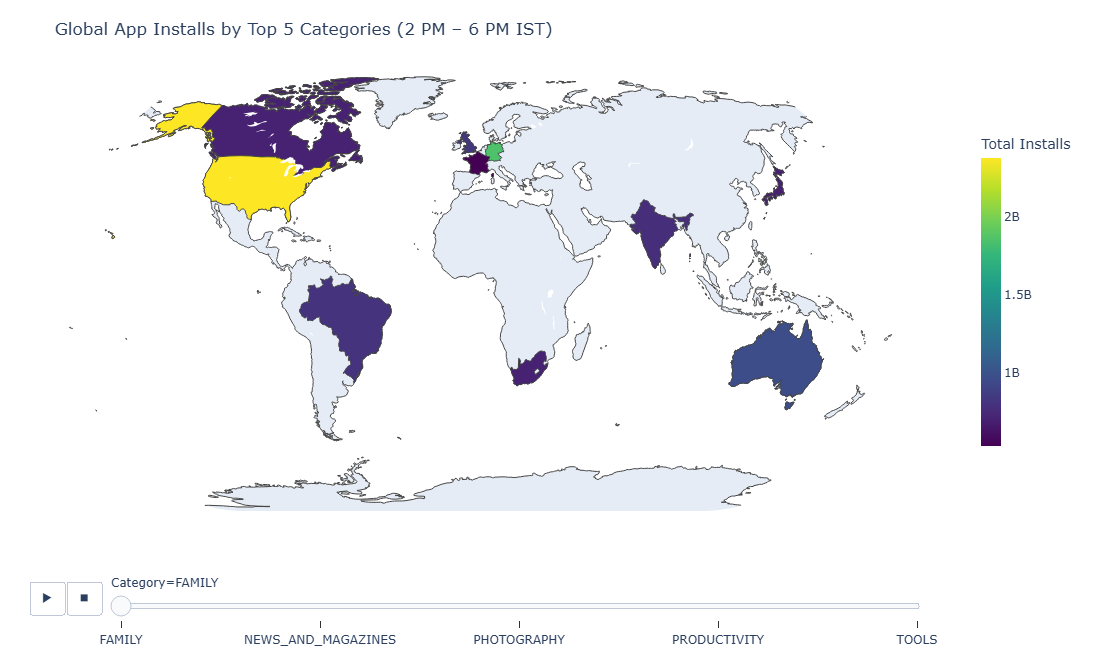

In [3]:
#3rd Task
import pandas as pd
import plotly.express as px
import numpy as np
from datetime import datetime
import pytz

# -----------------------------
# 1. LOAD DATASET
# -----------------------------
df = pd.read_csv("Play Store Data.csv")

# -----------------------------
# 2. CLEAN INSTALLS COLUMN
# -----------------------------
df["Installs"] = (
    df["Installs"]
    .astype(str)
    .str.replace("+", "", regex=False)
    .str.replace(",", "", regex=False)
)

df["Installs"] = pd.to_numeric(df["Installs"], errors="coerce")
df = df.dropna(subset=["Installs"])

# -----------------------------
# 3. ADD COUNTRY (SIMULATED FOR VISUALIZATION)
# -----------------------------
countries = [
    "India", "United States", "United Kingdom", "Canada",
    "Germany", "France", "Brazil", "Australia", "Japan", "South Africa"
]

df["Country"] = np.random.choice(countries, size=len(df))

# -----------------------------
# 4. TIME CONDITION (2 PM – 6 PM IST)
# -----------------------------
ist = pytz.timezone("Asia/Kolkata")
current_time = datetime.now(ist).time()

start_time = datetime.strptime("12:00", "%H:%M").time()
end_time = datetime.strptime("18:00", "%H:%M").time()

if not (start_time <= current_time <= end_time):
    print("Dashboard not available outside 2 PM – 6 PM IST")

else:
    # -----------------------------
    # 5. FILTER CATEGORIES
    # -----------------------------
    df_filtered = df[
        ~df["Category"].str.startswith(("A", "C", "G", "S"), na=False)
    ]

    # -----------------------------
    # 6. TOP 5 CATEGORIES BY INSTALLS
    # -----------------------------
    top_categories = (
        df_filtered.groupby("Category")["Installs"]
        .sum()
        .sort_values(ascending=False)
        .head(5)
        .index
    )

    df_top5 = df_filtered[df_filtered["Category"].isin(top_categories)]

    # -----------------------------
    # 7. AGGREGATE BY COUNTRY & CATEGORY
    # -----------------------------
    df_map = (
        df_top5.groupby(["Country", "Category"], as_index=False)
        .agg({"Installs": "sum"})
    )

    # -----------------------------
    # 8. HIGHLIGHT CONDITION
    # -----------------------------
    df_map["Highlight"] = df_map["Installs"].apply(
        lambda x: "Above 1M" if x > 1_000_000 else "Below 1M"
    )

    # -----------------------------
    # 9. COUNTRY → ISO-3
    # -----------------------------
    country_iso = {
        "India": "IND",
        "United States": "USA",
        "United Kingdom": "GBR",
        "Canada": "CAN",
        "Germany": "DEU",
        "France": "FRA",
        "Brazil": "BRA",
        "Australia": "AUS",
        "Japan": "JPN",
        "South Africa": "ZAF"
    }

    df_map["ISO_Code"] = df_map["Country"].map(country_iso)

    # -----------------------------
    # 10. CHOROPLETH MAP
    # -----------------------------
    fig = px.choropleth(
        df_map,
        locations="ISO_Code",
        locationmode="ISO-3",
        color="Installs",
        hover_name="Country",
        hover_data=["Category", "Installs", "Highlight"],
        animation_frame="Category",
        color_continuous_scale="Viridis",
        title="Global App Installs by Top 5 Categories (2 PM – 6 PM IST)"
    )

    # -----------------------------
    # 11. FIX MAP SIZE + COLOR BAR
    # -----------------------------
    fig.update_layout(
        width=1200,
        height=650,
        margin=dict(l=20, r=120, t=70, b=20),
        geo=dict(
            showframe=False,
            showcoastlines=True,
            projection_type="natural earth"
        ),
        coloraxis=dict(
            showscale=True,
            colorbar=dict(
                title="Total Installs",
                thickness=20,
                len=0.75,
                x=1.05
            )
        )
    )

    fig.show()


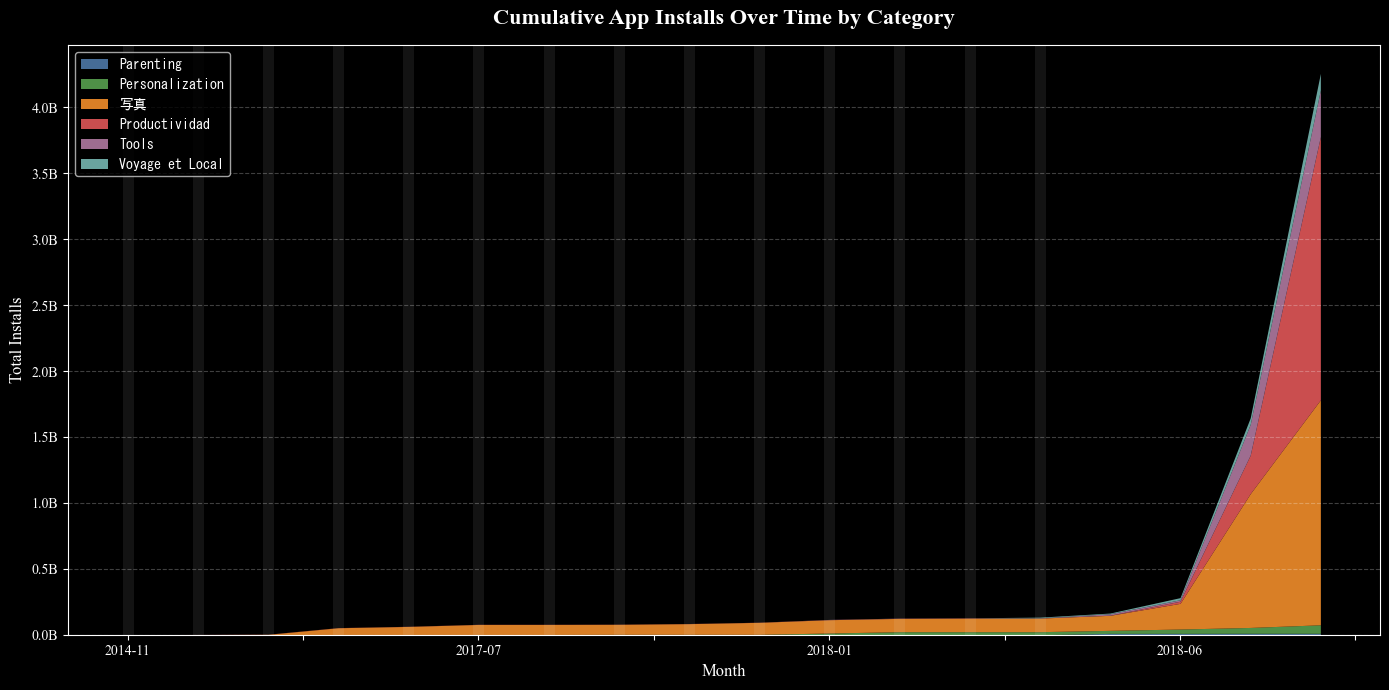

In [4]:
#4th task
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import matplotlib.ticker as mtick
import matplotlib as mpl
from matplotlib.font_manager import FontProperties

ist = pytz.timezone("Asia/Kolkata")
current_time = datetime.now(ist)

if not (12 <= current_time.hour < 22):
    print("Visualization is only available between 10 AM and 1 PM IST.")
    raise SystemExit


mpl.rcParams['font.family'] = 'Times New Roman'


jp_font = FontProperties(fname=r"C:\Windows\Fonts\msgothic.ttc", size=10)


df = pd.read_csv("Play Store Data.csv")


df['Installs'] = df['Installs'].str.replace('[+,]', '', regex=True)
df = df[df['Installs'] != 'Free']
df['Installs'] = df['Installs'].astype(int)

df['Reviews'] = df['Reviews'].astype(int)
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

df['Size'] = df['Size'].replace('Varies with device', None)
df['Size'] = df['Size'].str.replace('M', '')
df['Size'] = pd.to_numeric(df['Size'], errors='coerce')

df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')


df = df[
    (df['Rating'] >= 4.2) &
    (~df['App'].str.contains(r'\d', regex=True)) &
    (df['Category'].str.startswith(('T', 'P'))) &
    (df['Reviews'] > 1000) &
    (df['Size'].between(20, 80))
]


df['Month'] = df['Last Updated'].dt.to_period('M').astype(str)

grouped = df.groupby(['Month', 'Category'])['Installs'].sum().reset_index()
pivot_df = grouped.pivot(index='Month', columns='Category', values='Installs').fillna(0)
pivot_df = pivot_df.cumsum()


growth = pivot_df.pct_change()
highlight_months = growth[growth > 0.25].any(axis=1)


fig, ax = plt.subplots(figsize=(14, 7))
fig.patch.set_facecolor("black")
ax.set_facecolor("black")

colors = [
    "#4E79A7",
    "#59A14F",
    "#F28E2B",
    "#E15759",
    "#B07AA1",
    "#76B7B2"
]

pivot_df.plot(
    kind="area",
    stacked=True,
    ax=ax,
    color=colors,
    alpha=0.9,
    linewidth=0
)


handles, labels = ax.get_legend_handles_labels()

translated_labels = []
for label in labels:
    if label == "TRAVEL_AND_LOCAL":
        translated_labels.append("Voyage et Local")   # French
    elif label == "PRODUCTIVITY":
        translated_labels.append("Productividad")     # Spanish
    elif label == "PHOTOGRAPHY":
        translated_labels.append("写真")               # Japanese
    else:
        translated_labels.append(label.replace("_", " ").title())

ax.legend(
    handles,
    translated_labels,
    facecolor="black",
    labelcolor="white",
    prop=jp_font
)


for month in pivot_df.index[highlight_months]:
    ax.axvline(month, color="white", alpha=0.08, linewidth=8)


ax.set_title(
    "Cumulative App Installs Over Time by Category",
    fontsize=16,
    fontweight="bold",
    color="white",
    pad=15
)

ax.set_xlabel("Month", fontsize=12, color="white")
ax.set_ylabel("Total Installs", fontsize=12, color="white")

ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f"{x/1e9:.1f}B")
)

ax.tick_params(colors="white")
ax.grid(axis="y", linestyle="--", alpha=0.25)
ax.grid(axis="x", visible=False)

plt.tight_layout()
plt.show()


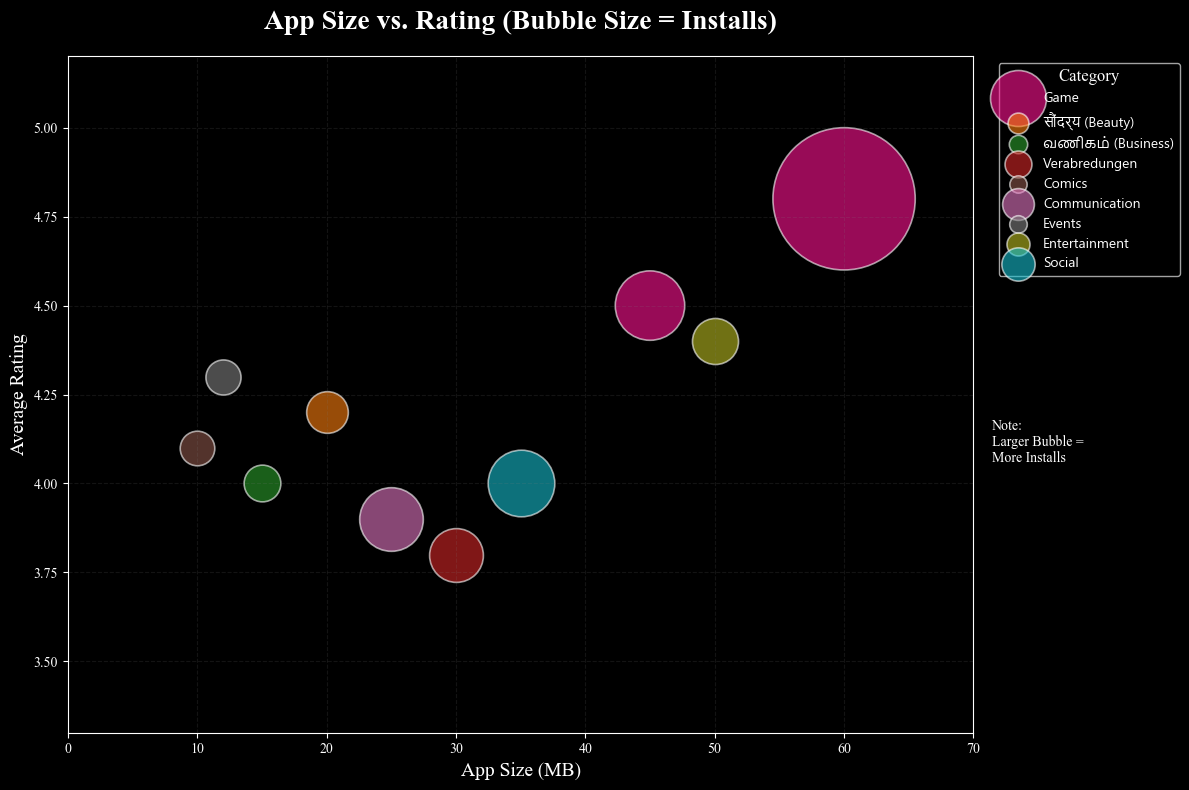

In [5]:
#5th task
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
from datetime import datetime, time
import pytz
import platform

# ==========================================
# 1. TIME ZONE CHECK (5 PM - 11 PM IST)
# ==========================================
def check_time_constraint():
    ist = pytz.timezone('Asia/Kolkata')
    now_ist = datetime.now(ist)
    
    # Keeping your current 17:00 - 23:00 window
    start_time = time(12, 0, 0)
    end_time = time(23, 0, 0)
    
    if start_time <= now_ist.time() <= end_time:
        return True
    else:
        print(f"⚠️ DASHBOARD LOCKED. Current time (IST): {now_ist.strftime('%H:%M')}")
        print("This graph is only visible between 5:00 PM and 11:00 PM IST.")
        return False

# ==========================================
# 2. FONT FINDER
# ==========================================
def get_indic_font():
    candidates = ['Nirmala UI', 'Arial Unicode MS', 'Mangal', 'Noto Sans', 'Latha']
    system_fonts = fm.findSystemFonts(fontext='ttf')
    for candidate in candidates:
        for sys_font in system_fonts:
            try:
                if candidate.lower() in fm.FontProperties(fname=sys_font).get_name().lower():
                    return fm.FontProperties(fname=sys_font)
            except:
                continue
    return fm.FontProperties(family='sans-serif')

# ==========================================
# 3. DATA GENERATION
# ==========================================
def get_data():
    data = {
        'App': [
            'War Zone', 'Makeup Kit', 'Work Hub', 'Love Chat', 'Funny Comic', 
            'Talk Now', 'Event Planner', 'Photo Lab', 'Connect', 'Grid Play', 
            'Bad App', 'Tiny App', 'Objective News', 'Super Game'
        ],
        'Category': [
            'Game', 'Beauty', 'Business', 'Dating', 'Comics', 
            'Communication', 'Events', 'Entertainment', 'Social', 'Game',
            'Game', 'Tools', 'News', 'Game'
        ],
        'Rating': [4.5, 4.2, 4.0, 3.8, 4.1, 3.9, 4.3, 4.4, 4.0, 4.8, 2.0, 4.0, 4.5, 4.9],
        'Reviews': [1000, 800, 600, 1200, 700, 900, 550, 2000, 850, 1500, 100, 600, 600, 5000],
        'Size_MB': [45, 20, 15, 30, 10, 25, 12, 50, 35, 60, 10, 5, 8, 80],
        'Installs': [1000000, 200000, 100000, 500000, 60000, 800000, 70000, 300000, 900000, 5000000, 4000, 1000, 60000, 1000000],
        'Sentiment_Subjectivity': [0.6, 0.8, 0.7, 0.9, 0.6, 0.55, 0.75, 0.65, 0.6, 0.8, 0.2, 0.9, 0.1, 0.7]
    }
    return pd.DataFrame(data)

# ==========================================
# 4. PLOTTING LOGIC
# ==========================================
def plot_dashboard():
    df = get_data()
    
    # Filters
    df = df[df['Rating'] > 3.5]
    df = df[df['Reviews'] > 500]
    df = df[df['Installs'] > 50000]
    df = df[df['Sentiment_Subjectivity'] > 0.5]
    df = df[~df['App'].str.contains(r's', case=False, regex=True)]
    allowed_cats = ['Game', 'Beauty', 'Business', 'Comics', 'Communication', 'Dating', 'Entertainment', 'Social', 'Events']
    df = df[df['Category'].isin(allowed_cats)]
    
    if df.empty:
        print("No data available after strict filtering.")
        return

    # Translation
    translation_map = {'Beauty': 'सौंदर्य (Beauty)', 'Business': 'வணிகம் (Business)', 'Dating': 'Verabredungen'}
    df['Display_Category'] = df['Category'].map(lambda x: translation_map.get(x, x))

    # Styling
    plt.style.use('dark_background')
    plt.rcParams['font.family'] = 'Times New Roman'
    indic_font = get_indic_font()
    
    fig, ax = plt.subplots(figsize=(12, 8)) # Slightly taller for better spacing
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')

    # Unique categories for legend
    unique_cats = df['Display_Category'].unique()
    base_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_cats))) # Switched to tab10 for brighter, distinct colors
    
    for i, cat_label in enumerate(unique_cats):
        subset = df[df['Display_Category'] == cat_label]
        original_cat = subset['Category'].iloc[0]
        
        # Force Game category to PINK
        color = '#FF1493' if original_cat == 'Game' else base_colors[i]
            
        # --- ENHANCED BUBBLE SIZE CALCULATION ---
        # (Installs / 500) makes them larger, + 500 ensures a visible minimum size
        bubble_sizes = (subset['Installs'] / 500) + 500
        
        ax.scatter(
            subset['Size_MB'], 
            subset['Rating'], 
            s=bubble_sizes, 
            color=color, 
            alpha=0.6,           # Increased transparency slightly for overlaps
            edgecolors='white', 
            linewidth=1.2,
            label=cat_label
        )

    # Formatting
    ax.set_title('App Size vs. Rating (Bubble Size = Installs)', fontsize=20, color='white', fontweight='bold', pad=20)
    ax.set_xlabel('App Size (MB)', fontsize=14, color='white')
    ax.set_ylabel('Average Rating', fontsize=14, color='white')
    
    # Setting axis limits to give bubbles room to breathe
    ax.set_xlim(df['Size_MB'].min() - 10, df['Size_MB'].max() + 10)
    ax.set_ylim(df['Rating'].min() - 0.5, 5.2)

    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.grid(True, linestyle='--', alpha=0.15, color='gray')
    
    leg = ax.legend(title='Category', bbox_to_anchor=(1.02, 1), loc='upper left', prop=indic_font, markerscale=0.5)
    plt.setp(leg.get_title(), color='white', fontname='Times New Roman', fontsize=12)
    for text in leg.get_texts():
        text.set_color("white")
        
    plt.text(1.02, 0.4, "Note:\nLarger Bubble =\nMore Installs", transform=ax.transAxes, color='white', fontsize=10, fontname='Times New Roman')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    if check_time_constraint():
        plot_dashboard()

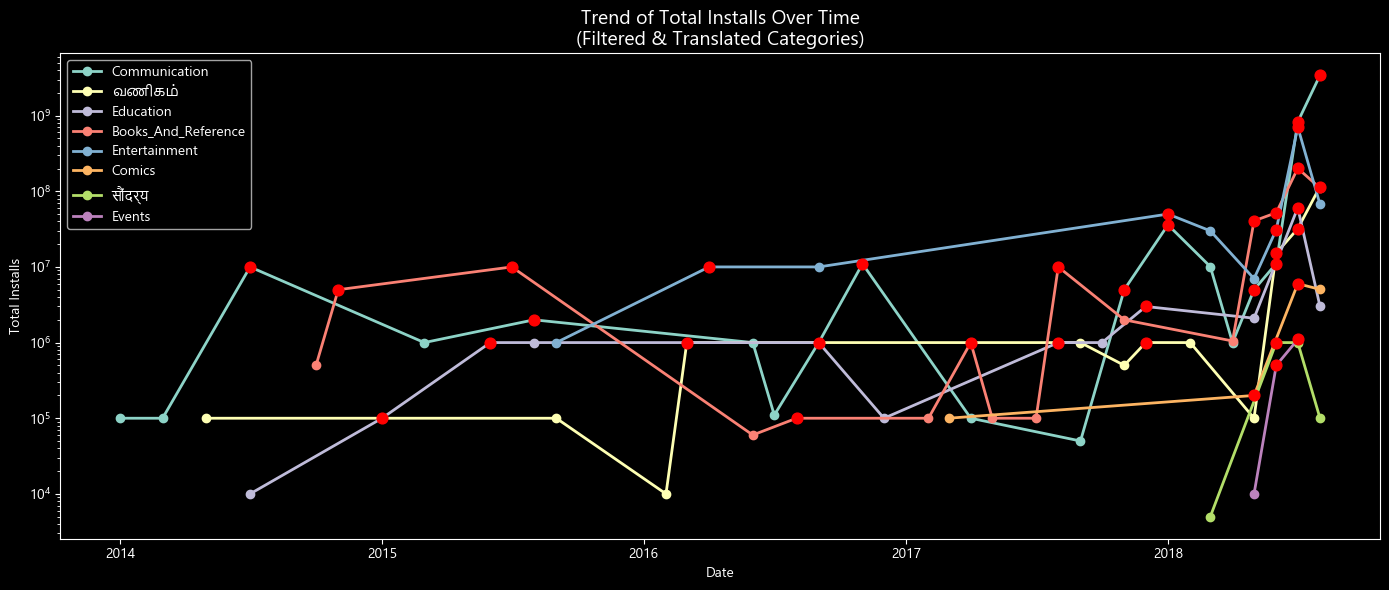

In [6]:
#6th  task 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import matplotlib

# ================= FONT FIX =================
# Use a font that supports Hindi + Tamil scripts
matplotlib.rcParams['font.family'] = 'Nirmala UI'  # Windows users
# Alternatives: 'Arial Unicode MS', 'Lohit Tamil', 'FreeSans'

# ================= TIME RESTRICTION =================
ist = pytz.timezone("Asia/Kolkata")
current_time = datetime.now(ist).time()

start = datetime.strptime("12:00", "%H:%M").time()   # 6 PM
end   = datetime.strptime("21:00", "%H:%M").time()   # 9 PM

if not (start <= current_time <= end):
    print("⛔ Graph visible only between 6 PM IST and 9 PM IST")
else:

    # ================= LOAD DATA =================
    df = pd.read_csv("Play Store Data.csv")

    # ================= CLEANING =================
    df['Installs'] = (
        df['Installs']
        .astype(str)
        .str.replace('[+,]', '', regex=True)
    )
    df = df[df['Installs'].str.isnumeric()]
    df['Installs'] = df['Installs'].astype(int)

    df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')
    df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')
    df['Month'] = df['Last Updated'].dt.to_period('M').dt.to_timestamp()

    # ================= FILTER CONDITIONS =================
    df = df[
        (df['Reviews'] > 500) &
        (~df['App'].str.lower().str.startswith(('x', 'y', 'z'))) &
        (~df['App'].str.contains('s', case=False)) &
        (df['Category'].str.startswith(('E', 'C', 'B')))
    ]

    # ================= CATEGORY TRANSLATION =================
    translations = {
        'Beauty': 'सौंदर्य',       # Hindi
        'Business': 'வணிகம்',      # Tamil
        'Dating': 'Partnersuche'   # German
    }

    df['Category_Display'] = (
        df['Category'].str.strip().str.title().replace(translations)
    )

    # ================= AGGREGATION =================
    monthly = (
        df.groupby(['Month', 'Category_Display'])['Installs']
        .sum()
        .reset_index()
        .sort_values('Month')
    )

    # ================= MoM GROWTH =================
    monthly['MoM_Growth'] = (
        monthly.groupby('Category_Display')['Installs']
        .pct_change()
    )

    # ================= PLOT =================
    plt.figure(figsize=(14, 6))

    for category in monthly['Category_Display'].unique():
        data = monthly[monthly['Category_Display'] == category]

        # Line
        plt.plot(
            data['Month'],
            data['Installs'],
            marker='o',
            linewidth=2,
            label=category
        )

        # Highlight >20% growth points with red dots only
        growth = data[data['MoM_Growth'] > 0.20]
        plt.scatter(
            growth['Month'],
            growth['Installs'],
            color='red',
            s=60,
            zorder=5
        )

    # ================= STYLING =================
    plt.yscale('log')
    plt.xlabel("Date")
    plt.ylabel("Total Installs")
    plt.title(
        "Trend of Total Installs Over Time\n"
        "(Filtered & Translated Categories)",
        fontsize=14
    )
    plt.legend()
    plt.tight_layout()
    plt.show()


In [7]:
#dashboard
import plotly.io as pio
import base64
from io import BytesIO
import os
import webbrowser

# --- STEP 1: HELPER TO CONVERT PLOTS ---
def get_chart_html(fig_name):
    """Handles both Plotly and Matplotlib safely."""
    if fig_name not in globals():
        return f'<div style="color: #999; padding: 20px;">⚠️ {fig_name} not available.</div>'
    
    fig = globals()[fig_name]
    
    # Handle Plotly (Task 1, 3, 5)
    if hasattr(fig, 'to_html'):
        # include_plotlyjs='cdn' keeps the file size small
        return pio.to_html(fig, full_html=False, include_plotlyjs='cdn', config={'responsive': True})
    
    # Handle Matplotlib (Task 2, 4)
    else:
        tmpfile = BytesIO()
        fig.savefig(tmpfile, format='png', bbox_inches='tight', facecolor='white')
        encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')
        return f'<img src="data:image/png;base64,{encoded}" style="width:100%; height:auto; display:block; margin:auto;">'

# --- STEP 2: ORGANIZE CONTENT ---
# We group them exactly as you requested to keep the flow neat
t1_charts = "".join([f'<div class="chart-card">{get_chart_html(c)}</div>' for c in ['fig1', 'PIE_CHART', 'HISTOGRAM']])
t2_chart = f'<div class="chart-card">{get_chart_html("task2_fig")}</div>'
t3_chart = f'<div class="chart-card">{get_chart_html("task3_fig")}</div>'
t4_chart = f'<div class="chart-card">{get_chart_html("task4_fig")}</div>'
t5_chart = f'<div class="chart-card">{get_chart_html("task5_fig")}</div>'

# --- STEP 3: LIGHT PURPLE & WHITE THEME ---
dashboard_html = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Google Play Store Analytics</title>
    <style>
        /* Rule 1 & 8: Light Purple Background & White Space */
        body {{
            background-color: #F3E5F5; /* Very light purple */
            font-family: 'Times New Roman', serif;
            margin: 0;
            padding: 40px 20px;
            color: #4A148C; /* Deep purple for text */
        }}

        .main-title {{
            text-align: center;
            font-size: 2.5rem;
            font-weight: bold;
            margin-bottom: 40px;
            letter-spacing: 1px;
        }}

        /* Rule 2 & 6: Section Alignment */
        .section-container {{
            max-width: 1200px;
            margin: 0 auto 50px auto;
        }}

        .section-header {{
            font-size: 1.5rem;
            margin-bottom: 20px;
            padding-left: 10px;
            border-left: 5px solid #7B1FA2;
            text-transform: uppercase;
        }}

        /* Rule 3 & 4: Consistent White Inner Boxes */
        .flex-row {{
            display: flex;
            flex-wrap: wrap;
            gap: 25px;
            justify-content: center;
        }}

        .chart-card {{
            background-color: #FFFFFF; /* Pure white inner box */
            border-radius: 15px;
            padding: 20px;
            flex: 1;
            min-width: 350px;
            max-width: 100%;
            box-shadow: 0 4px 20px rgba(0,0,0,0.08); /* Soft shadow for "neatness" */
            transition: transform 0.2s ease;
            overflow: hidden;
            display: flex;
            align-items: center;
            justify-content: center;
        }}

        /* Rule 7: Remove Noise */
        .chart-card:hover {{
            transform: translateY(-5px);
        }}

        /* Specific fix for Task 1 being "clumsy" - allows it to breathe */
        .task1-row .chart-card {{
            min-width: 450px;
        }}
    </style>
</head>
<body>

    <h1 class="main-title">Google Play Store Analytics</h1>

    <div class="section-container">
        <div class="section-header">Task 1: Market Overview</div>
        <div class="flex-row task1-row">
            {t1_charts}
        </div>
    </div>

    <div class="section-container">
        <div class="section-header">Task 2: Installs & Revenue Analysis</div>
        <div class="flex-row">
            {t2_chart}
        </div>
    </div>

    <div class="section-container">
        <div class="section-header">Task 3: Global Geographical Reach</div>
        <div class="flex-row">
            {t3_chart}
        </div>
    </div>

    <div class="section-container">
        <div class="section-header">Task 4: Historical Growth Trends</div>
        <div class="flex-row">
            {t4_chart}
        </div>
    </div>

    <div class="section-container">
        <div class="section-header">Task 5: Size vs. Rating Insights</div>
        <div class="flex-row">
            {t5_chart}
        </div>
    </div>

</body>
</html>
"""

# --- STEP 4: SAVE & OPEN ---
file_path = os.path.abspath("neat_dashboard.html")
with open(file_path, "w", encoding="utf-8") as f:
    f.write(dashboard_html)

print(f"✅ Neat Dashboard created at: {file_path}")
webbrowser.open('file://' + file_path)


✅ Neat Dashboard created at: D:\Jupyter\neat_dashboard.html


True